In [1]:
import numpy as np
from sklearn import cluster
from sklearn import datasets
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle
import math

In [2]:
# ----------------------------------functions for unsupervised evaluation----------------------------------
def distance(points, point): # compute the distance from a point to other/another points
    if len(points.shape) == 1:
        return np.sqrt(sum((points - point) ** 2))
    else:
        return np.sqrt(np.sum((points - point) ** 2, axis = 1))  #Ouput: float or array of float

In [3]:
# TODO 1: compute SSE
#  Input: data - the 2d locations of data points
#         r_clusters - the clusters obtained by some clustering algorithm
#         r_centers - the centers of clusters
#  HINT: (1) for frequently used function, like computing the distance between a point and other point(s), it is better to write it as an independent sub-function for multiple calling
#        (2) utilize the nd-array's built-in functions/utilities to make your code concise and efficient
#        (3) OVERALL COMMENT: r_cluster and r_labels contain the same information but in different form, you can use r_labels to replace r_cluster as the input, if you prefer it

def compute_SSE(data, r_clusters, r_centers):
  SSE=0
  for i, cluster in enumerate(r_clusters):
    for index in cluster:
      SSE += distance(data[index], r_centers[i])**2
  return SSE

def compute_SSB(data, r_clusters, r_centers): # computer SSB
    center_1 = np.mean(data, axis=0)
    SSB = 0
    for k in range(len(r_clusters)):
        SSB += len(r_clusters[k]) * np.sum(distance(r_centers[k, :] ,center_1) ** 2)
    return SSB

In [4]:
# TODO 2: compute the average silhouette coefficient (for all points)

def nearest_cluster_dist(data, datapoint, r_clusters, cluster_index):
  b = [[] for _ in range(len(r_clusters))]
  for i, cluster in enumerate(r_clusters):
    if i != cluster_index:
      for point in cluster:
          b[i].append(distance(data[point], datapoint))
      b[i] = np.average(b[i])
  b = list(filter(None, b))
  return min(b)

def compute_avg_silhouette_coefficient(data, r_clusters):
    sc = []    

    for i, cluster in enumerate(r_clusters):
      for index in cluster:
        a = []
        datapoint = data[index]
        for point in cluster:
          a.append(distance(data[point], datapoint))
        a_avg = sum(a)/(len(cluster)-1)
        b = nearest_cluster_dist(data, datapoint, r_clusters, i)
        sc.append((b - a_avg)/max(a_avg,b))
    avg_sc = np.average(sc)
    return avg_sc

In [5]:
#from numpy.matrixlib.defmatrix import N
# TODO 3: compute the proximity matrix
#   HINT: use the similarity matrix, instead of dissimilarity
#         normalization is needed, i.e., the maximum value of similarity is 1

def compute_proximity_matrix(data):
  N = data.shape[0]
  proximity = np.zeros((N,N))
  dist=[]
  for i in data:
    dist.append(distance(data,i))
  normalisation=np.max(dist)
  
  for index,value in enumerate(data):
    for index_, item in enumerate(data):
      proximity[index][index_] = (normalisation-distance(value,item))/normalisation

  return proximity


def compute_clustering_matrix(r_labels): # compute the clustering matrix
    N = data.shape[0]
    clustering = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if r_labels[i] == r_labels[j]:  # check whether two points belong to the same cluster
                clustering[i,j] = 1
    return clustering

# TODO 4: compute the correlation between two matrices A and B
def correlation(A, B):
  mean_A = np.mean(A)
  mean_B = np.mean(B)
  a = []
  b = []
  ab = []
  a_square = []
  b_square = []
  sum_ab = []
  sum_a_square = []
  sum_b_square = []

  for i in range(len(A)):
    a.append(A[i]-mean_A)
    b.append(B[i]-mean_B)

  ab = np.multiply(a,b)
  a_square = np.square(a)
  b_square = np.square(b)
  sum_ab = np.sum(ab)
  sum_a_square = np.sum(a_square)
  sum_b_square = np.sum(b_square)
  correlation = sum_ab / np.sqrt(sum_a_square*sum_b_square)
  return correlation

In [6]:
from re import I
# ----------------------------------functions for supervised evaluation----------------------------------
# ---------- classification-oriented evaluation ----------------
# TODO 5: compute the precision and recall
#  Input: labels - the known labels (ground truth)
#         r_clusters - the clusters obtained by some clustering algorithm
def compute_precision_and_recall(labels, r_clusters):
  N = len(r_clusters)
  matrix = np.zeros((N,N))
  for n in range(N):
    for index in r_clusters[n]:
      matrix[n, labels[index]] += 1
  precision = (matrix.T / np.sum(matrix, axis = 1)).T
  recall = matrix / np.sum(matrix, axis=0)
  return precision, recall

def compute_purity(precision): # compute the purity
    return np.sum(np.max(precision, axis=1))

# TODO 6: compute the entropy
#  HINT: the 0 element(s) in precision will not be considered for computing entropy
def compute_entropy(precision, r_clusters):
  #number of objects in cluster i 
  m_i = [len(item) for item in r_clusters]
  #number of objects
  m = sum(m_i)
  entropy = 0

  for index, value in enumerate(precision):
      ei = 0
      for i,val in enumerate(value):
          if val != 0:
              ei-=((val * np.log2(val)))
      entropy += (m_i[index]/m) * ei
  return entropy


#---------- similarity-oriented evaluation ----------------
# TODO 7: compute rand_statistic and Jaccard_coeff
#  Input: labels - the known labels (ground truth)
#         r_lables - the clustering result by some algorithm, to be evaluated
def compute_binary_similarity(labels, r_labels):  
  f = {}

  for item_l, item_rl in list(zip(compute_clustering_matrix(labels), compute_clustering_matrix(r_labels))):
    for l, r_l in list(zip(item_l, item_rl)):
      f[f'f_{l}{r_l}']  =  f.get(f'f_{l}{r_l}', 0) + 1 

  rand_statistic = (f.get('f_0.00.0',0)+f.get('f_1.01.0',0))/(f.get('f_0.00.0',0)+f.get('f_1.01.0', 0)+ f.get('f_0.01.0',0)+f.get('f_1.00.0',0))
  Jaccard_coeff = (f.get('f_1.01.0',0))/(f.get('f_1.01.0',0)+ f.get('f_0.01.0',0)+f.get('f_1.00.0',0))
  
  return rand_statistic, Jaccard_coeff

In [7]:
# ------------------------------------------ other functions --------------------------------------
def generate_sparse_data(n): #random sparse data points. Input: the number of points
    data = []
    for i in range(n):
        data.append([np.random.randn(), np.random.randn()])  # the location of one point
    data = np.array(data)
    return data

def labels_to_clusters(labels): # derive the clusters from labels. Example: if the labels are [0,0,1,1], then the clusters will be [[0,1], [2,3]] where the number is the index of data points
    cluster_num = np.max(labels) + 1
    clusters = []
    for k in range(cluster_num):
        clusters.append([])
    for i in range(len(labels)):
        clusters[labels[i]].append(i)
    return clusters

def plot_data(data): # plot the data points
    fig = plt.figure(figsize=(7, 4.5))
    ax  = fig.add_subplot(1, 1, 1)
    ax.scatter(data[:,0], data[:,1], c='black')
    plt.xlabel('x')
    plt.ylabel('y')

# TODO 10 (optional): personalized your plot style
def plot_clusters(data, r_clusters): # plot the data points with different colors for different clusters
    fig = plt.figure(figsize=(7, 4.5))
    ax  = fig.add_subplot(1, 1, 1)
    for k in range(len(r_clusters)):
        ax.scatter(data[r_clusters[k],0], data[r_clusters[k],1])
    plt.xlabel('x')
    plt.ylabel('y')

def plot_line(values, x_ticks, x_label, y_label): # plot the variation of values
    fig = plt.figure(figsize=(7, 4.5))
    ax  = fig.add_subplot(1, 1, 1)
    ax.plot(values)
    plt.xticks(range(len(values)), x_ticks)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

# TODO 11 (optional): personalized your plot style
def plot_matrix(matrix, axis_name): # plot a matrix
    n = matrix.shape[0]
    fig = plt.figure(figsize=(7, 4.5))
    ax  = fig.add_subplot(1, 1, 1)
    im = ax.imshow(matrix, cmap="Blues",  vmin=0)   # you can change cmap to use different colors
    tick_locator = ticker.MaxNLocator()
    cb1 = plt.colorbar(im)
    cb1.locator = tick_locator
    cb1.update_ticks()
    plt.xticks(range(n))
    plt.yticks(range(n))
    plt.xlabel(axis_name)
    plt.ylabel(axis_name)

labels: [ 0  1  2  1  2  0  1  1 -1 -1 -1  0 -1 -1  2  1  1  0  2  2 -1 -1  0  1
  2  0  1  1  1  0  1  0  1  0  1  2  1  2  0  2  2  1  0  0  2  1 -1  2
  0  0  1  1  2  0 -1  1  2 -1  1 -1  1  2  0  2  0  0  1  2  0 -1  0  1
  0  2  1  0  1  2  0  2 -1 -1  0  2  2  1  2  1 -1  1  2  0  0  2  0  1
 -1 -1  1 -1]
clusters: [[0, 5, 11, 17, 22, 25, 29, 31, 33, 38, 42, 43, 48, 49, 53, 62, 64, 65, 68, 70, 72, 75, 78, 82, 91, 92, 94], [1, 3, 6, 7, 15, 16, 23, 26, 27, 28, 30, 32, 34, 36, 41, 45, 50, 51, 55, 58, 60, 66, 71, 74, 76, 85, 87, 89, 95, 98], [2, 4, 8, 9, 10, 12, 13, 14, 18, 19, 20, 21, 24, 35, 37, 39, 40, 44, 46, 47, 52, 54, 56, 57, 59, 61, 63, 67, 69, 73, 77, 79, 80, 81, 83, 84, 86, 88, 90, 93, 96, 97, 99]]


Part 1: Unsupervised evaluation
proximity matrix:
 [[1.   0.07 0.48 ... 0.87 0.15 0.39]
 [0.07 1.   0.47 ... 0.06 0.91 0.51]
 [0.48 0.47 1.   ... 0.41 0.55 0.91]
 ...
 [0.87 0.06 0.41 ... 1.   0.15 0.32]
 [0.15 0.91 0.55 ... 0.15 1.   0.57]
 [0.39 0.51 0.91 ... 0.32 0.57 1.  ]

ValueError: The number of FixedLocator locations (0), usually from a call to set_ticks, does not match the number of ticklabels (1).

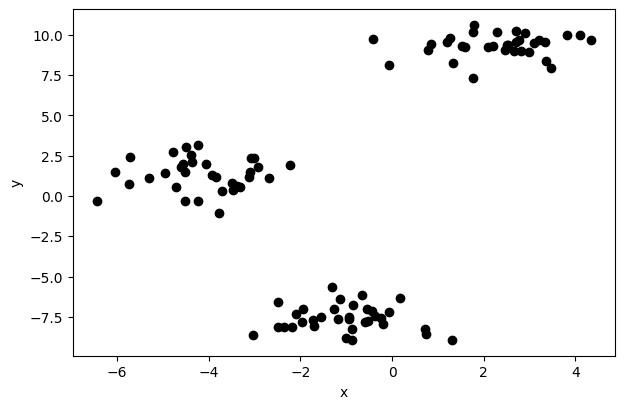

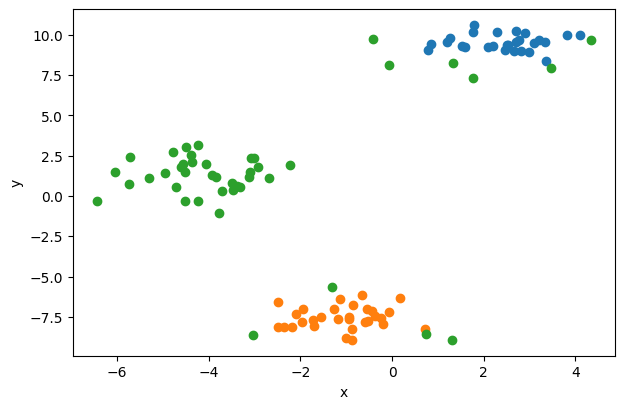

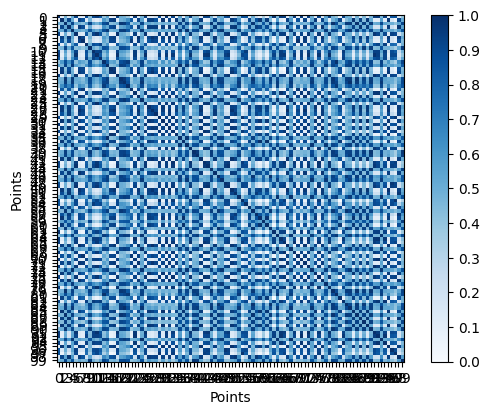

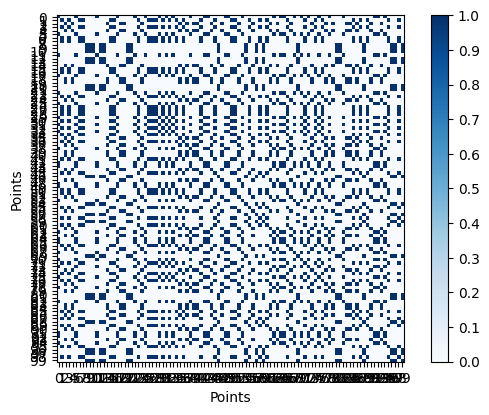

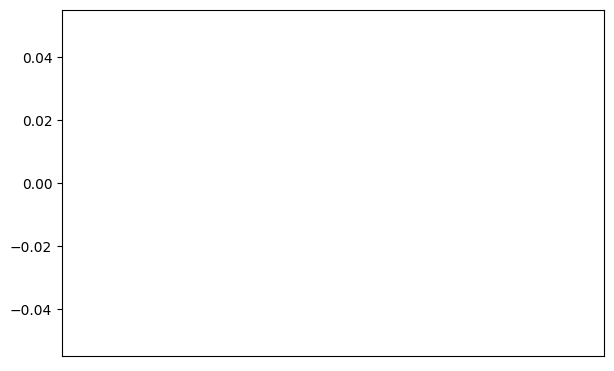

In [8]:
#-------------------------------------------- The main process ------------------------------------------
# TODO 8: generate two datasets, one is in random sparse structure while another distributed as specific overall shapes
#  HINT: (1) use the tiny dataset to check the correctness of your functions above. You may also need to build other tiny datasets for further check
#        (2) for random sparse data points: call function generate_sparse_data(n), and you can choose any parameter "n" (n >= 50) as you like
#        (3) for data points distributed as different shapes: use functions in package sklearn.datasets, like datasets.make_circles(...), datasets.make_moons(...), datasets.make_blobs(...), etc. Choose parameters as you like (at least 50 points and 3 clusters)
#------------------------------------- Step 1: generate different datasets -------------------------------------

# ----- 1.1 tiny dataset (only for debugging) --------
#data = np.array([[0,1],[0,2], [0,4], [0,5]])  # the location of 2d data points
#labels = np.array([0,0,1,1])  # the known classification
#n_list = [2] # the number of clusters

# ----- 1.2 random sparse data points (only for unsupervised evaluation) --------
data = generate_sparse_data(100)
n_list = [2,4,5] # for testing the best number of clusters in unsupervised evaluation
SSEs, ASCs  = [], [] #ditto

# ----- 1.3 data points distributed as different shapes (for both supervised and unsupervised evaluations) --------
#data, labels = datasets.make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1.0, center_box=(-10.0, 10.0), shuffle=True, random_state=None)

#n_list = [2,3,4] # for testing the best number of clusters in unsupervised evaluation
#n_list = [3] # the fixed number of clusters in supervised evaluation

plot_data(data)
for n_cluster in n_list:
    # ------------------------------------- Step 2: Clustering ------------------------------------------
    # TODO 9: replace the kmeans algorithm by the DBSCAN algorithm (optional: you can also try other algorithms)
    #  HINT: call function cluster.DBSCAN(...) (KMeans)
    result = cluster.KMeans(n_clusters=n_cluster, random_state=0).fit(data) # call the kmeans algorithm
    #result = cluster.DBSCAN(min_samples=10,eps=1).fit(data) # call the DBSCAN algorithm

    r_labels = result.labels_  # the cluster labels for points
    r_clusters = labels_to_clusters(r_labels) # the clusters
    r_centers = result.cluster_centers_  # the centers of clusters
    print('labels:', r_labels)
    print('clusters:', r_clusters)
    print('cluster centers:\n', r_centers)
    plot_clusters(data, r_clusters) # plot the data points
    print('\n')

    #--------------------------------- Step 3: Unsupervised evaluation ---------------------------------
    #---------- 3.1 evaluation with a given number of clusters -----------------
    print('Part 1: Unsupervised evaluation')
    SSE = compute_SSE(data, r_clusters, r_centers)
    SSEs.append(SSE)
    print('SSE:', np.round(SSE,2))
    SSB = compute_SSB(data, r_clusters, r_centers)
    print('SSB:', np.round(SSB,2))
    average_silhouette_coefficient = compute_avg_silhouette_coefficient(data, r_clusters)
    ASCs.append(average_silhouette_coefficient)
    print('average silhouette coefficient:', np.round(average_silhouette_coefficient,2))
    proximity_matrix = compute_proximity_matrix(data)
    print('proximity matrix:\n', np.round(proximity_matrix,2))
    plot_matrix(proximity_matrix, 'Points')
    clustering_matrix = compute_clustering_matrix(r_labels)
    print('clustering matrix:\n', np.round(clustering_matrix,2))
    plot_matrix(clustering_matrix, 'Points')
    corr = correlation(proximity_matrix, clustering_matrix)
    print('corr:', np.round(corr,2))
    print('\n')
    """"
    #---------------------------------Step 4: Supervised evaluation -------------------------------
    #---------- 4.1 classification-oriented evaluation ----------------
    print('Part2: Supervised evaluation - classification-oriented')
    precision, recall = compute_precision_and_recall(labels, r_clusters)
    print('precision:\n', np.round(precision,2))
    print('recall:\n', np.round(recall,2))
    purity = compute_purity(precision)
    print('purity:', np.round(purity,2))
    entropy = compute_entropy(precision, r_clusters)
    print('entropy:', np.round(entropy,2))
    print('\n')
    
    # ------------ 4.2 similarity-oriented evaluation ----------------
    print('Part 3: Supervised evaluation - similarity-oriented')
    rand_statistic, Jaccard_coeff = compute_binary_similarity(labels, r_labels)
    print('rand_statistic:', np.round(rand_statistic,2))
    print('Jaccard_coeff:', np.round(Jaccard_coeff,2))
    print('\n')
    """
#------- 3.2 select the best number of clusters for unsupervised clustering -----------
plot_line(SSEs, [str(n) for n in n_list], 'number of clusters', 'SSE')
plot_line(ASCs, [str(n) for n in n_list], 'number of clusters', 'Average silhouette coefficient')